# My domaine.nc first notebook

## Description

My first Jupyter notebook are dedicated to the domaine.nc platform data.
Data are providing by the Kaggle project : https://www.kaggle.com/code/adriensales/domaine-nc

Some many projects turn around domaine.nc for example : api, mobile application and others was created based on this

In [1]:
%pip install --upgrade duckdb --quiet
%pip install --upgrade plotly-express seaborn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import duckdb

con = duckdb.connect(database='./domaines-nc.duckdb', read_only=True)
con.sql("show tables").to_df()

,name
0,all_dns
1,dns_providers
2,domaines
3,domaines_details


## all_dns

Let's take a look on all_dns table. First, display his definition and some rows.

In [3]:
con.sql("show all_dns").to_df()

,column_name,column_type,null,key,default,extra
0,dns,VARCHAR,YES,None,None,None


Seems row are pure duplicates

In [4]:
con.sql("select dns, count(*) nb from all_dns group by dns order by count(*) desc").to_df()

,dns,nb
0,ns2.mls.nc,810
1,ns1.mls.nc,804
2,dnss.lagoon.nc,735
3,dnst.lagoon.nc,734
4,dnsp.lagoon.nc,722
...,...,...
2345,ns-669.awsdns-19.net,1
2346,ns-1261.awsdns-29.org,1
2347,villawave,1
2348,villawaves,1


In [5]:
con.sql("select distinct(dns) from all_dns").to_df()

,dns
0,ns1.xlnet.nc
1,ns2-auth.rollernet.us
2,ns2.esquare.nc
3,nsdal01.crucial.com.au
4,ns7.wixdns.net
...,...
2345,ns2.amerinoc.com
2346,ns1.usa-invest.us
2347,golgoth-001.virtual.nc
2348,ns-2033.awsdns-62.co.uk


Some lines are very similar only number make the differences.

In [6]:
con.sql("select distinct(*) from all_dns where dns like 'ns%awsdns%com'").to_df()

,dns
0,ns-337.awsdns-42.com
1,ns-468.awsdns-58.com
2,ns-113.awsdns-14.com
3,ns-210.awsdns-26.com
4,ns-137.awsdns-17.com
...,...
231,ns-142.awsdns-17.com
232,ns-388.awsdns-48.com
233,ns-181.awsdns-22.com
234,ns-429.awsdns-53.com


We can looking for more unicity without them, we fall, now, at ~800 rows

In [7]:
query = """select 
           distinct(regexp_replace(regexp_replace(dns,'[^a-zA-Z\\.\\-\\s]', ' ', 'g'), '\\s+', '[n]', 'g')) as dns_wo_numbers
           from all_dns where dns like '%aws%'
        """
con.sql(query).to_df()

,dns_wo_numbers
0,ns-[n].awsdns-[n].com
1,s-[n].awsdns-[n].org
2,ns-[n].awsdns-[n].org
3,nc-[n]awsdns-[n].com
4,ns-[n].awsdns-[n].net
5,ns-[n].awsdns-[n].co.uk


For more readability, externalize the regexp block to python function for future usages

In [8]:
import re

def get_dns_wo_numbers(dns: str) -> str:
    result = re.sub(r'[^a-zA-Z\.\-\s]', ' ', dns)
    return re.sub(r'\s+', '[n]', result)

result = con.sql("SELECT count(*) FROM duckdb_functions() where function_name = 'get_dns_wo_numbers'").fetchall()

# remove if exists to prevent re-execution
if result[0][0] == 1:
    con.remove_function("get_dns_wo_numbers")
con.create_function("get_dns_wo_numbers", get_dns_wo_numbers)

con.sql("select dns, get_dns_wo_numbers(dns) dns_wo_numbers from all_dns").to_df()


,dns,dns_wo_numbers
0,ns-408.awsdns-51.com,ns-[n].awsdns-[n].com
1,ns-1687.awsdns-18.co.uk,ns-[n].awsdns-[n].co.uk
2,ns-1488.awsdns-58.org,ns-[n].awsdns-[n].org
3,ns-854.awsdns-42.net,ns-[n].awsdns-[n].net
4,ns1.xlnet.nc,ns[n].xlnet.nc
...,...,...
17674,ns-1721.awsdns-23.co.uk,ns-[n].awsdns-[n].co.uk
17675,ns-232.awsdns-29.com,ns-[n].awsdns-[n].com
17676,ns-1379.awsdns-44.org,ns-[n].awsdns-[n].org
17677,ariella.ns.cloudflare.com,ariella.ns.cloudflare.com


In [9]:
query = """select get_dns_wo_numbers(dns) dnsName, count(*) dns_wo_numbers
           from all_dns
           where dns like '%.nc%'
           group by get_dns_wo_numbers(dns)
           order by count(*) desc
           limit 10
        """
con.sql(query).to_df()

,dnsName,dns_wo_numbers
0,ns[n].mls.nc,1616
1,ns[n].canl.nc,780
2,dnss.lagoon.nc,735
3,dnst.lagoon.nc,734
4,dnsp.lagoon.nc,722
5,ns[n].xlnet.nc,477
6,ns[n].nautile.nc,417
7,ns[n].dsp.nc,214
8,ns[n].webcom.nc,207
9,ns[n].esquare.nc,180


Using chart libraries

<Axes: xlabel='dns_name'>

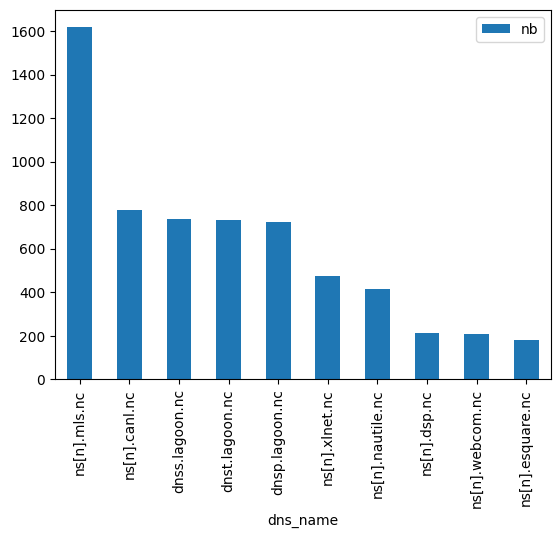

In [10]:
query = """select get_dns_wo_numbers(dns) dns_name, count(*) nb
           from all_dns
           where dns like '%.nc%'
           group by get_dns_wo_numbers(dns)
           order by count(*) desc
           limit 10
        """

df = con.query(query).to_df()
df.plot.bar(x='dns_name')

## dns_provider

Same things for table `dns_providers`

In [11]:
con.sql("show dns_providers").to_df()

,column_name,column_type,null,key,default,extra
0,dns,VARCHAR,YES,None,None,None
1,provider,VARCHAR,YES,None,None,None


In [12]:
con.sql("select dns, count(*) as nb from dns_providers group by dns order by count(*) desc").to_df()

,dns,nb
0,ns2.mls.nc,810
1,ns1.mls.nc,804
2,dnss.lagoon.nc,735
3,dnst.lagoon.nc,734
4,dnsp.lagoon.nc,722
...,...,...
2345,ns-1684.awsdns-18.co.uk,1
2346,ns-613.awsdns-12.net,1
2347,ns-117.awsdns-14.com,1
2348,ns-751.awsdns-29.net,1


Providers can, unfornately, be truncated like `co.uk` are present

In [13]:
con.sql("select * from dns_providers where provider = 'awsdns-18.co' limit 1").to_df()

,dns,provider
0,ns-1687.awsdns-18.co.uk,awsdns-18.co


In [14]:
con.sql("select * from dns_providers where length(dns) - length(replace(dns, '.', '')) <> 2").to_df()

,dns,provider
0,ns-1687.awsdns-18.co.uk,awsdns-18.co
1,ns-1974.awsdns-54.co.uk,awsdns-54.co
2,ns1.bdm.microsoftonline.com,bdm.microsoftonline
3,ns2.bdm.microsoftonline.com,bdm.microsoftonline
4,ns3.bdm.microsoftonline.com,bdm.microsoftonline
...,...,...
3083,javier.ns.cloudflare.com,ns.cloudflare
3084,jo.ns.cloudflare.com,ns.cloudflare
3085,ns-1721.awsdns-23.co.uk,awsdns-23.co
3086,ariella.ns.cloudflare.com,ns.cloudflare


In [15]:
query = """select distinct(length(dns) - length(replace(dns, '.', ''))) as dot_count
           from dns_providers
           where length(dns) - length(replace(dns, '.', '')) <> 2
        """

con.sql(query).to_df()


,dot_count
0,1
1,3
2,0
3,4


In [17]:
query = """select *
           from dns_providers
           where length(dns) - length(replace(dns, '.', '')) = 4
           limit 20
        """

con.sql(query).to_df()

,dns,provider
0,hybrid4434.ca.ns.planethoster.net,ca.ns
1,hybrid4434-1.ca.ns.planethoster.net,ca.ns
2,hybrid752.fr.ns.planethoster.net,fr.ns
3,hybrid752-1.fr.ns.planethoster.net,fr.ns
4,hybrid4434.ca.ns.planethoster.net,ca.ns
5,hybrid4434-1.ca.ns.planethoster.net,ca.ns
6,ns1.syd3.hostingplatform.net.au,syd3.hostingplatform
7,ns2.syd3.hostingplatform.net.au,syd3.hostingplatform
8,hybrid4434.ca.ns.planethoster.net,ca.ns
9,hybrid4434-1.ca.ns.planethoster.net,ca.ns
